In [1]:
using DelimitedFiles
using Plots
pyplot()
using Statistics

In [2]:
#defining functions that will aid in cleaning data and calculations

nanmean(x) = mean(filter(!isnan, x))

function flatsmooth(light, t, degree)
    lower = Int((degree-1)/2)
    upper = Int((degree+1)/2)
    l = length(light)
    lightsmoothed = zeros(l)
    
    for i in upper:length(light)-lower
        lightsmoothed[i] = mean(light[i-lower:i+lower])
    end
    
    for j in findall(lightsmoothed .== 0)
        lightsmoothed[j] = light[j]
    end
    return lightsmoothed, t
end

flatsmooth (generic function with 1 method)

In [3]:
file = readdlm("exoplanet-data.txt");
t = file[:, 1];
light = file[:, 2];

In [4]:
#replacing NaNs with mean of 4 nearest points
for i in findall(isnan.(light))
    light[i] = nanmean(light[i-2:i+2])
end

# sanity check
print(sum(isnan.(light)))

0

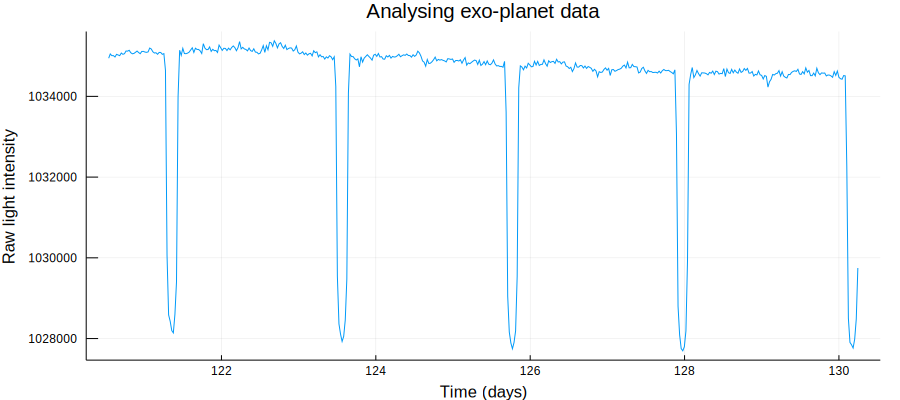

In [5]:
#initial plot

gr(size = (900, 400))
plot(t, light, label = "Light intensity", legend = :none)
title!("Analysing exo-planet data")
xlabel!("Time (days)")
ylabel!("Raw light intensity")

# a) orbital period

In [6]:
i = 1
mins = zeros(0)
while i < length(light)
    last = i+100
    if last > length(light)
        last = length(light)
    end
    append!(mins, argmin(light[i:last])+i)
#     println(i)
    i += 100
end
mins = Int.(mins.-1);

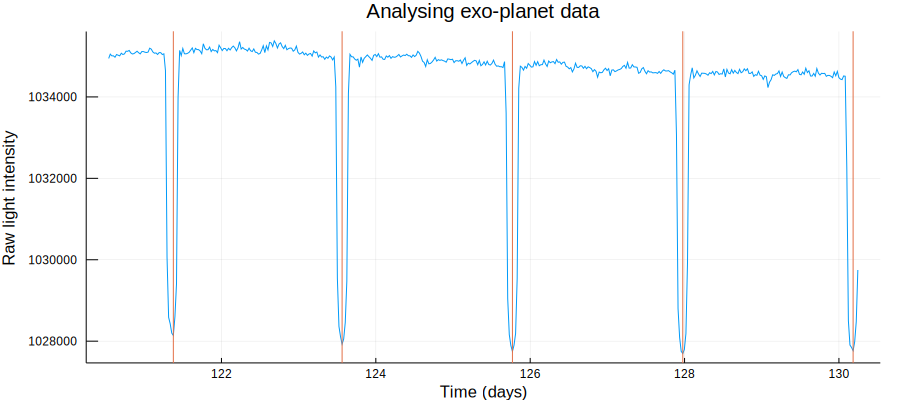

In [7]:
plot(t, light, legend = :none)
vline!(t[mins])

title!("Analysing exo-planet data")
xlabel!("Time (days)")
ylabel!("Raw light intensity")

In [8]:
period = mean(t[mins[i+1]]-t[mins[i]] for i in 1:4)
println("The orbital period is ", period, " (Earth days).")

The orbital period is 2.2017997215898504 (Earth days).


Here I divided raw data into several chunks and found the minimum for each chunk(marked by red vertical lines on the plot above). The orbital period is then calculated by averaging over the the amount of time between each minimum.

# some preparation before moving forward

In [9]:
light3, time3 = flatsmooth(light, t, 3);

difference = abs.(light3.-light);
differenceratio = difference ./ light
cutoffhigh = 1.9*mean(differenceratio)
lows = findall(differenceratio .> cutoffhigh)
cutofflow = mean(light[lows])
for i in findall(light.<cutofflow)
    append!(lows, i)
end

highs = 1:length(light)
highs = setdiff(highs, lows);

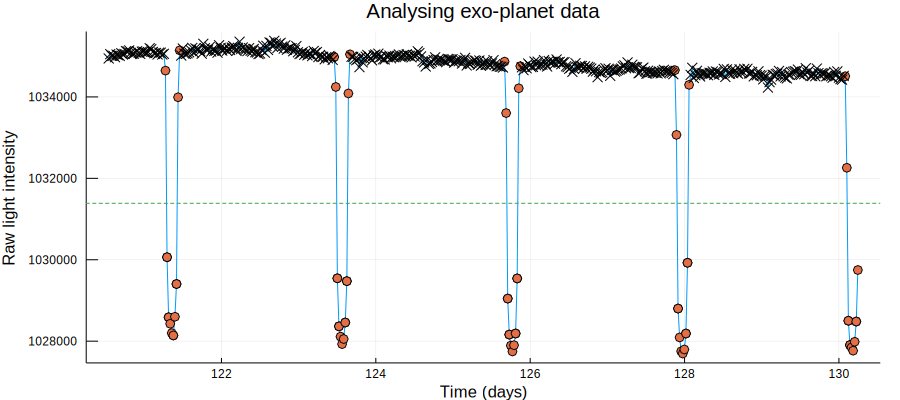

In [10]:
plot(t, light)
scatter!(t[lows], light[lows], legend = :none, m = :o)
hline!([cutofflow], ls = :dash)
scatter!(t[highs], light[highs], m = :x)
title!("Analysing exo-planet data")
xlabel!("Time (days)")
ylabel!("Raw light intensity")

This was to achieve separation between the unobstructed(when the planet is not in front of the sun from our view) and obstructed fluxes. For `cutoffhigh`, I worked out the difference between the original data and smoothed data, then decided on a somewhat arbitrary cutoffpoint. 

This somewhat works as the datapoints in the "dips" will be more affected by the smoothing and will have higher absolute differences. However, datapoints right at the bottom of the dips were relatively safe from this filter which is why I then calculated `cutofflow` and categorised all points below it into `lows`. 

In the plot above, the blue line is from the original data, red circles are the filtered "obstructed" points, crosses are "unobstructed" points and the green dashed horizontal signifies the lower cut off point. 

It is apparent that this method is not perfect as we see a lot of "unobstructed" points being wrongly classified as being otherwise at the start and end of the eclipses, but this shouldn't significantly affect the calculations that are to follow. 

# b) estimating ratio of radii

In [11]:
Fhigh = mean(light[highs])
Flow = mean(light[mins])
ratio = sqrt((Fhigh-Flow)/Fhigh)
println("The ratio between the planetary and solar radii is ", ratio)

The ratio between the planetary and solar radii is 0.08221934600632287


It is then straightforward to estimate the ratio, which is derived as follows: 

$$F_{high} = \pi R^2$$
$$F_{low} = \pi (R^2 - r^2)$$

$$\frac{F_{high}-F_{low}}{F_{high}} = \frac{r^2}{R^2}$$

Where R and r are the radius of the sun and the planet, respectively. To get the ration we just need to squareroot everything.

# c) estimating transit time

In [12]:
starts = zeros(0)
ends = zeros(0)
for i in 1:length(highs)-1
    if highs[i+1]-highs[i] > 1
        append!(starts, highs[i])
        append!(ends, highs[i+1])
    end
end
starts = Int.(starts)
ends = Int.(ends);

In [13]:
transittime = mean(t[ends].-t[starts])
println("The transit time is ", transittime, " (Earth days).")

The transit time is 0.23499482797524252 (Earth days).


Here I worked out where the gaps in the unobstructed fluxes are and estimated the transit time by averaging over the lengths of the gaps in time.